In [18]:
####### load packages ##########
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer,word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy import sparse,interp
import pickle
from sklearn.decomposition import TruncatedSVD,PCA, NMF
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn import metrics,grid_search
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_curve, auc,precision_recall_curve,roc_auc_score
from scipy.sparse import hstack
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier 
from sklearn.datasets import make_classification
from collections import Counter
import time



%matplotlib inline
plt.style.use('ggplot')

In [19]:
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import pandas as pd
import os
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

%matplotlib inline
plt.style.use('ggplot')
from collections import Counter
from sklearn.feature_extraction.text import HashingVectorizer
import math
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, roc_curve,auc
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.decomposition import TruncatedSVD
from time import time
import time

<h1> 1. Data Munging and Cleaning

In [20]:
###### read file ##########
dire = os.getcwd()
tr = pd.read_csv(dire+'/train.csv',header = 0,encoding="utf-8")
re = pd.read_csv(dire+'/resources.csv',header = 0,encoding="utf-8")

In [21]:
{x:len(re[x].unique()) for x in re.columns}

{'description': 332929, 'id': 260115, 'price': 26890, 'quantity': 208}

We can find that for each id, there may be multiple items, so we need create some new variables to summurize them before merging the resources table and train table.

In [22]:
###### join datagrames#########
re_new = re.groupby('id',as_index=False).agg({"price":sum,
                                              "quantity":sum,
                                            "description":'count'})
re_new_min = re.groupby('id',as_index=False).agg({"price":min,
                                              "quantity":min})
re_new_max = re.groupby('id',as_index=False).agg({"price":max,
                                              "quantity":max})

re_new_min.rename(columns={'price':"price_min",'quantity':"quantity_min"},inplace=True)
re_new_max.rename(columns={'price':"price_max",'quantity':"quantity_max"},inplace=True)

data1 = tr.merge(re_new,how='left',left_on=['id'], right_on=['id'])
data2 = data1.merge(re_new_min,how='left',left_on=['id'], right_on=['id'])
data = data2.merge(re_new_max,how='left',left_on=['id'], right_on=['id'])

In [23]:
print(data.shape)
{x:len(data[x].unique()) for x in data.columns}

(182080, 23)


{'description': 100,
 'id': 182080,
 'price': 79684,
 'price_max': 20755,
 'price_min': 13636,
 'project_essay_1': 147689,
 'project_essay_2': 180984,
 'project_essay_3': 6360,
 'project_essay_4': 6337,
 'project_grade_category': 4,
 'project_is_approved': 2,
 'project_resource_summary': 179730,
 'project_subject_categories': 51,
 'project_subject_subcategories': 407,
 'project_submitted_datetime': 180439,
 'project_title': 164282,
 'quantity': 376,
 'quantity_max': 193,
 'quantity_min': 160,
 'school_state': 51,
 'teacher_id': 104414,
 'teacher_number_of_previously_posted_projects': 401,
 'teacher_prefix': 6}

In [24]:
data.sample(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,...,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,description,price_min,quantity_min,price_max,quantity_max
158731,p038245,73f31762440e926e361a64c735e7e8d0,Ms.,SD,2017-01-18 11:25:27,Grades 9-12,History & Civics,History & Geography,Show Me the World,"Our high school is located in Sioux Falls, Sou...",...,My students need virtual reality headsets to a...,0,1,19.99,25,1,19.99,25,19.99,25
105105,p063477,2d4a5e851255932ba59850c9fc76e990,Mrs.,CA,2016-08-11 00:15:27,Grades PreK-2,"Literacy & Language, Special Needs","Literature & Writing, Special Needs",Special Tech for Special Needs!,"My classroom inspires dreamers, scientists, ex...",...,My students need need a mini iPad to maximize ...,8,0,299.99,1,1,299.99,1,299.99,1
88470,p114027,46a51cc2297b72433f6050191b2f7d92,Mrs.,AL,2017-04-21 11:35:26,Grades 9-12,Literacy & Language,"ESL, Literature & Writing",Innovative Noteworthy Note Taking,My students are the best. We live in an extrem...,...,My students need the smart writing system will...,3,1,199.00,1,1,199.00,1,199.00,1
87948,p200628,5d7857af3f9489f63c2292f1aacfd118,Mr.,WV,2016-11-21 19:19:18,Grades 3-5,Health & Sports,Gym & Fitness,Bands for Energetic Students,Coming into the new year I have a great group ...,...,My students need a set of bouncy bands for the...,3,1,11.86,12,1,11.86,12,11.86,12
174250,p093551,4b7823fdd95f943225ecdd91c42f3045,Mr.,KY,2016-11-21 13:29:55,Grades 9-12,"Applied Learning, History & Civics","College & Career Prep, History & Geography",The Florence Project,We are a new school with about 60 students. Mo...,...,My students need a MacBook so they can produce...,0,1,1999.99,1,1,1999.99,1,1999.99,1


In [25]:
############ check NA #############
data.isna().sum()

id                                                   0
teacher_id                                           0
teacher_prefix                                       4
school_state                                         0
project_submitted_datetime                           0
project_grade_category                               0
project_subject_categories                           0
project_subject_subcategories                        0
project_title                                        0
project_essay_1                                      0
project_essay_2                                      0
project_essay_3                                 175706
project_essay_4                                 175706
project_resource_summary                             0
teacher_number_of_previously_posted_projects         0
project_is_approved                                  0
price                                                0
quantity                                             0
descriptio

<h3> 1.1 Deal with NA  </h3>   
   
* NA in teacher_prefix, simply drop it
* NA in essay : The reasom for NA is because after April, the requirement for propal has changed. So we can combine essay 1&2 and essay 3&4

In [26]:
#### deal with NA in teacher prefix ########
data = data.dropna(subset=['teacher_prefix'])
data = data.fillna('')
##### combine essays ########
data.loc[data.project_essay_3!="",'project_essay_1']=data.loc[data.project_essay_3!="",['project_essay_1','project_essay_2']].astype(str).sum(axis=1)
data.loc[data.project_essay_3!="",'project_essay_2']=data.loc[data.project_essay_3!="",['project_essay_3','project_essay_4']].astype(str).sum(axis=1)
#### drop useless column and factorize categorical column########
data['project_grade_category_n'] = data.project_grade_category.factorize()[0]
data['teacher_prefix_n'] = data.teacher_prefix.factorize()[0]
data['school_state_n'] = data.school_state.factorize()[0]

data = data.drop(["project_essay_3","project_essay_4","project_grade_category",
                  "teacher_prefix","school_state"],axis=1)
data = data.drop(["id","teacher_id"],axis=1)
data.rename(columns={'description':"count_items"},inplace=True)

In [27]:
######deal with datetime variable #######
data['project_submitted_datetime'] =  pd.to_datetime(data['project_submitted_datetime'], format='%Y-%m-%d %H:%M:%S')
data['year'] = data['project_submitted_datetime'].dt.year
data['month'] = data['project_submitted_datetime'].dt.month
data['day'] = data['project_submitted_datetime'].dt.day
data['hour'] = data['project_submitted_datetime'].dt.hour
data = data.drop("project_submitted_datetime",axis=1)

Because catgory and subcatgory is highly correlated, we only use subcatgory here.   
The unique value of subcatgory is 407, which is caused by multi-subcatgories of a certain proposal. So we first split the subcatgores then create dummy variables on the column.

In [28]:
############### split subcat#########
data = data.join(data['project_subject_subcategories'].str.split(', ', 1, expand=True).rename(columns={0:'sub1', 1:'sub2'}))
##find unique subcatgories######
subcat = list(data["sub1"].unique())
subcat.extend(list(data["sub2"].unique()))
subcatl = list(set(subcat))
#####create dummy variables by subcat
datat = pd.get_dummies(data[["sub1","sub2"]], prefix=['c1', 'c2'], dummy_na=True)
for l in subcatl:
    try:
        if "c1_"+str(l) in datat.columns:
            if "c2_"+str(l) in datat.columns:
                datat[str(l)] = datat["c1_"+str(l)] + datat["c2_"+str(l)]
            else:
                datat[str(l)] = datat["c1_"+str(l)]
        else:
            datat[str(l)] = datat["c2_"+str(l)]
    except KeyError as error:
        pass

need_col = [i for i in datat.columns if ("c1_" not in i and "c2_" not in i)]
############add new dummy variables to original dataframe#########
data = pd.concat([data, datat[need_col]], axis=1)

In [29]:
data = data.drop(["project_subject_subcategories","project_subject_categories","sub1","sub2"],axis=1)

We decide to use tf-idf to vectorize the text. In order to avoid losing some important information, we create some new features.

In [30]:
##### add length of essay as new variable ##########3
data["e1_len"] = data["project_essay_1"].str.len()
data["e2_len"] = data["project_essay_2"].str.len()
data["ttl_len"] = data["project_title"].str.len()
data["summ_len"] = data["project_resource_summary"].str.len()

In [31]:
data.columns

Index(['project_title', 'project_essay_1', 'project_essay_2',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'count_items', 'price_min', 'quantity_min',
       'price_max', 'quantity_max', 'project_grade_category_n',
       'teacher_prefix_n', 'school_state_n', 'year', 'month', 'day', 'hour',
       'Character Education', 'College & Career Prep', 'Performing Arts',
       'Economics', 'Environmental Science', 'Health & Wellness',
       'Mathematics', 'Visual Arts', 'Early Development', 'Extracurricular',
       'Gym & Fitness', 'Team Sports', 'History & Geography',
       'Literature & Writing', 'ESL', 'Civics & Government', 'Warmth',
       'Special Needs', 'Applied Sciences', 'Literacy', 'Other',
       'Nutrition Education', 'Parent Involvement', 'Foreign Languages',
       'Warmth, Care & Hunger', 'Community Service', 'Financial Literacy',
       'Care & Hunger', 'Social Sciences', 'Music

<h1> 2. Data Exploration </h1>  
First of all, check the ratio of approved/reject proposl.

In [32]:
target = 'project_is_approved'
sum(data.project_is_approved==1)/data.shape[0]

0.8476789911904918

So our target is to build a model whose accuracy > 84.7%

In [33]:
data.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,count_items,price_min,quantity_min,price_max,quantity_max,project_grade_category_n,...,Community Service,Financial Literacy,Care & Hunger,Social Sciences,Music,Health & Life Science,e1_len,e2_len,ttl_len,summ_len
count,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,...,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000,182076.000000
mean,11.237291,0.847679,297.728992,16.971693,5.940525,90.904270,4.107422,178.375881,7.666194,0.950158,...,0.003910,0.005251,0.012033,0.017295,0.028406,0.039407,681.639563,847.899542,32.466195,122.299002
std,28.016348,0.359333,366.719034,26.242178,8.348522,271.541285,11.604245,307.066371,15.994806,0.980016,...,0.062411,0.072270,0.109035,0.130369,0.166129,0.194561,201.816508,286.621504,13.437132,47.107662
min,0.000000,0.000000,0.660000,1.000000,0.000000,0.000000,1.000000,0.270000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,169.000000,248.000000,4.000000,25.000000
25%,0.000000,1.000000,104.480000,4.000000,1.000000,6.590000,1.000000,39.990000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,523.000000,642.000000,22.000000,83.000000
50%,2.000000,1.000000,205.980000,9.000000,3.000000,15.990000,1.000000,99.500000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,616.000000,740.000000,30.000000,111.000000
75%,9.000000,1.000000,379.000000,21.000000,7.000000,73.270000,2.000000,220.992500,6.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,796.000000,967.000000,41.000000,157.000000
max,451.000000,1.000000,9999.000000,930.000000,100.000000,9999.000000,800.000000,9999.000000,800.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2760.000000,5224.000000,141.000000,902.000000


<h3> 2.1 Visualiztion  </h3>   
In order to get a better shape, we remove the extreme value when plotting box plot.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


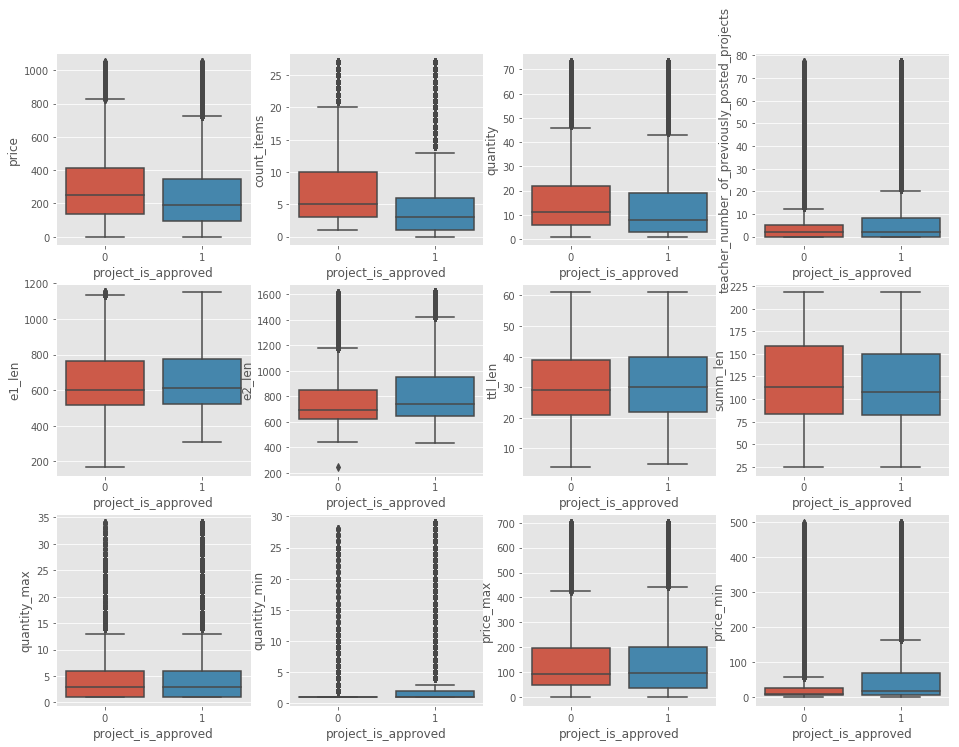

In [34]:
fig = plt.figure(figsize=(16,12))
gs = mpl.gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[0,0]);ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2]);ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0]);ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2]);ax8 = plt.subplot(gs[1,3])
ax9 = plt.subplot(gs[2,0]);ax10 = plt.subplot(gs[2,1])
ax11 = plt.subplot(gs[2,2]);ax12 = plt.subplot(gs[2,3])

q = data.price.quantile(.97)
temp = data[data.price<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.price,ax=ax1)

q = data.count_items.quantile(.97)
temp = data[data.count_items<q]
ax2 = sns.boxplot(x=temp.project_is_approved, y=temp.count_items,ax=ax2)

q = data.quantity.quantile(.97)
temp = data[data.quantity<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.quantity,ax=ax3)

q = data.teacher_number_of_previously_posted_projects.quantile(.97)
temp = data[data.teacher_number_of_previously_posted_projects<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.teacher_number_of_previously_posted_projects,ax=ax4)

q = data.e1_len.quantile(.97)
temp = data[data.e1_len<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.e1_len,ax=ax5)

q = data.e2_len.quantile(.97)
temp = data[data.e2_len<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.e2_len,ax=ax6)

q = data.ttl_len.quantile(.97)
temp = data[data.ttl_len<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.ttl_len,ax=ax7)

q = data.summ_len.quantile(.97)
temp = data[data.summ_len<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.summ_len,ax=ax8)

q = data.quantity_max.quantile(.97)
temp = data[data.quantity_max<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.quantity_max,ax=ax9)

q = data.quantity_min.quantile(.97)
temp = data[data.quantity_min<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.quantity_min,ax=ax10)

q = data.price_max.quantile(.97)
temp = data[data.price_max<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.price_max,ax=ax11)

q = data.price_min.quantile(.97)
temp = data[data.price_min<q]
ax1 = sns.boxplot(x=temp.project_is_approved, y=temp.price_min,ax=ax12)

From the plot, we can find ttl_len & summ_len doesn't matter, so we may drop them.

In [35]:
data = data.drop(["ttl_len","summ_len"],axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


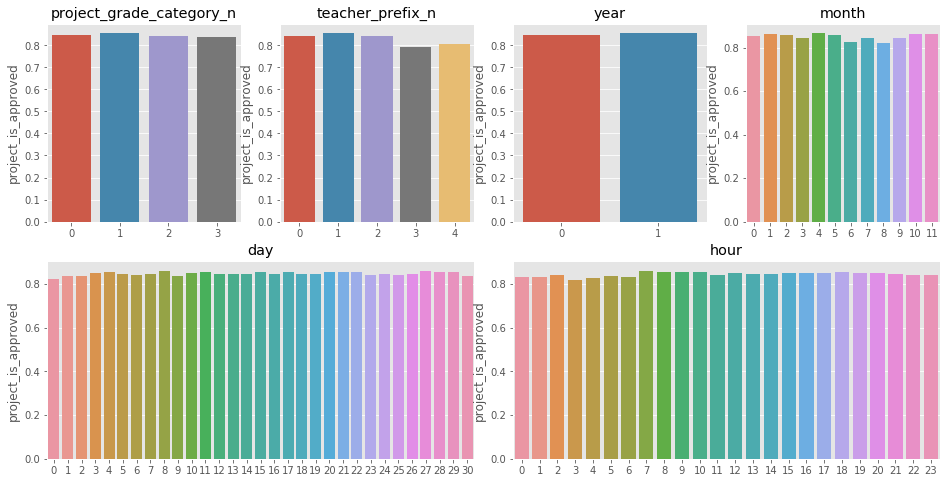

In [36]:
fig = plt.figure(figsize=(16,8))
gs = mpl.gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0,0]);ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2]);ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0:2]);ax6 = plt.subplot(gs[1,2:4])

ind = np.arange(4)
test = data.groupby(['project_grade_category_n'])['project_is_approved'].mean()
new = sns.barplot(ind,test,ax=ax1).set_title("project_grade_category_n")

ind = np.arange(5)
test = data.groupby(['teacher_prefix_n'])['project_is_approved'].mean()
new = sns.barplot(ind,test,ax=ax2).set_title("teacher_prefix_n")

ind = np.arange(2)
test = data.groupby(['year'])['project_is_approved'].mean()
new = sns.barplot(ind,test,ax=ax3).set_title("year")

ind = np.arange(12)
test = data.groupby(['month'])['project_is_approved'].mean()
new = sns.barplot(ind,test,ax=ax4).set_title("month")

ind = np.arange(31)
test = data.groupby(['day'])['project_is_approved'].mean()
new = sns.barplot(ind,test,ax=ax5).set_title("day")

ind = np.arange(24)
test = data.groupby(['hour'])['project_is_approved'].mean()
new = sns.barplot(ind,test,ax=ax6).set_title("hour")

<h3> 2.2 Get correlation matrix </h3>

In [37]:
needcol = ["e1_len","school_state_n","e2_len","price","teacher_number_of_previously_posted_projects",
          "hour","teacher_prefix_n","quantity","count_items","day","project_grade_category_n",
           "quantity_min","quantity_max","price_min","price_max","year","month"]
corref = data[needcol].corr()
corref[corref>0.5]

,e1_len,school_state_n,e2_len,price,teacher_number_of_previously_posted_projects,hour,teacher_prefix_n,quantity,count_items,day,project_grade_category_n,quantity_min,quantity_max,price_min,price_max,year,month
e1_len,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
school_state_n,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e2_len,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.62753,0.869845,NaN,NaN
teacher_number_of_previously_posted_projects,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hour,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
teacher_prefix_n,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.752615,NaN,NaN,NaN,NaN
count_items,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


price_max has a high corr with price and price_min, so drop price_max. Same reason for drop quanti_max

In [38]:
data = data.drop(["price_max","quantity_max"],axis=1)

<h3> 2.3 Deal with text data

In [39]:
text_col = ["project_essay_1","project_essay_2","project_title","project_resource_summary"]
####### split symbols with words to decrease dimension in tf-idf ####
for cname in text_col:
    data[cname] = data[cname].str.lower()
    data[cname] = data[cname].str.replace(r'[\\r|\\n]+', ' ')
    data[cname] = data[cname].str.replace(r'([^0-9|A-Z|a-z|-])+', ' \1 ')
############ combine text ##########
data["text"] = data[text_col].astype(str).sum(axis=1)

<h3> 2.3.1 Select feature manully

In [40]:
cachedStopWords = stopwords.words("english")
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
     return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
     return stem(tokenize(text))

def testFuncNew(text):
    ##### remove stopwords#####
    tokens = word_tokenize(str(text))
    textnew = [w for w in tokens if w not in cachedStopWords]
    return(textnew)

In [41]:
#####count words in approved text and rejected text respectively #####3
approve = data[data.project_is_approved==1].text.reset_index()
approve_text = ' '.join(approve.text)
reject = data[data.project_is_approved==0].text.reset_index()
reject_text = ' '.join(reject.text)
#####remove stopwords#######
approve_stop = testFuncNew(approve_text)
reject_stop = testFuncNew(reject_text)
#####get stem of the words##########
approve_stop_stem = stem(approve_stop)
reject_stop_stem = stem(reject_stop)
#################################
C_approve = Counter(approve_stop_stem)
C_reject =  Counter(reject_stop_stem)

For each word w, define R(w) = $\frac{\# in \, approve - \# in \, reject}{\# in\,all\,text}$,

In [42]:
#C_approve = pickle.load( open( "approve-stem.p", "rb" ))
#C_reject = pickle.load( open( "reject-stem.p", "rb" ))

In [43]:
def calculate_freq(coun,allc):
    new = {k: abs(v / allc[k]) for k, v in coun.items() if allc[k]>10}
    return(new)

C_all = C_approve + C_reject
C_approve.subtract(C_reject)
freq = calculate_freq(C_approve,C_all)
test = Counter(freq)

In [44]:
###### find most useful words########
n = 10000
importt = dict(test.most_common(n))
important = [k for k,v in importt.items()]
print(min(importt.values()))
important = list(importt.keys())
voca_tf = {important[i]:i for i in range(n)}

0.6


In [45]:
pickle.dump(data, open( "final_data.p", "wb" ) )

In [46]:
########do tf-idf only on these words#########
vectorizer_method1 = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None,vocabulary=voca_tf)
cty = data['text']
corpus = cty.copy()
tfs_method1 = vectorizer_method1.fit_transform(corpus)

<h3> 2.3.2 Applying tf-idf directly and use truncatedSVD to reduce dimension </h3>   
Because of the computational cost, our computer can only reduce dimension to 1000. In order to compare whether the new way to select features is effective, we did truncated PCA on the tf-idf matrix created by two meth0ds

In [53]:
vectorizer_method2 = TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True,norm=None)
tfs_method2 = vectorizer_method2.fit_transform(corpus)
ssvd = TruncatedSVD(n_components=100)
ssvd.fit(tfs_method2)
tfs_m2_100 = ssvd.fit_transform(tfs_method2)
ssvd = TruncatedSVD(n_components=1000)
ssvd.fit(tfs_method2)
tfs_m2_1000 = ssvd.fit_transform(tfs_method2)

In [54]:
ssvd = TruncatedSVD(n_components=100)
ssvd.fit(tfs_method1)
print("%.2f"%ssvd.explained_variance_ratio_.sum()) 
tfs_m1_100 = ssvd.fit_transform(tfs_method1)
ssvd = TruncatedSVD(n_components=1000)
ssvd.fit(tfs_method1)
print("%.2f"%ssvd.explained_variance_ratio_.sum()) 
tfs_m1_1000 = ssvd.fit_transform(tfs_method1)

0.22
0.81


<h1> 3. Model Selection </h1>
* Build model without text: to validate whether text information matters.   
* Build model with text(Method 1) ---- In Final_Project_2    
* Build model with text(Method 2) ---- In Final_Project_2      
  
  <h3> 3.1 Model without text  </h3>    
  In order to test whether the text is useful or not, we check certain criteria of the resulting models with and without text.

In [55]:
text_col = ["project_essay_1","project_essay_2","project_title","project_resource_summary","text"]
withouttext = set(data.columns) - set(text_col)
withouttext = list(withouttext - set([target]))
data_withouttext = data[withouttext]

#data_withouttext=sparse.csr_matrix(data_withouttext)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(data_withouttext, y, test_size=0.3, random_state=42)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127453, 46)
(127453,)
(54623, 46)
(54623,)


In [59]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [61]:
pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [64]:
start_time = time.time() 
logit = LogisticRegression(solver = "lbfgs")
logit.fit(X_train, y_train)
pred = logit.predict(X_test)
prob = logit.predict_proba(X_test)[:,1]
aucc = roc_auc_score(y_test, prob)
acc = accuracy_score(y_test,pred)
t = time.time()-start_time
print ("Accuracy %f ,AUC %f,time %lf secs\n"%(acc,aucc,t))

Accuracy 0.846676 ,AUC 0.691232,time 4.951747 secs



We can find that the fit is not good, so text info is important.